# Integrator probing

Including the bar can sometimes cause orbits to not be reverse integratable. I will modify integrator.f90 to print the intermediate accelerations so that they can be checked 


In [1]:
import tstrippy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import numpy as np
import matplotlib.pyplot as plt
import datetime
import bar_sensitivity_integration_timestep_and_time as bsitt

In [2]:
def backward_orbit(integrationparameters,staticgalaxy,initialkinematics,galacticbar):
    nObj = 1 # only integrating one object
    currenttime,dt,Ntimestep=integrationparameters
    MWname, MWparams = staticgalaxy
    x0,y0,z0,vx0,vy0,vz0 = initialkinematics
    barname,barparams,barpolycoeff = galacticbar

    tstrippy.integrator.setstaticgalaxy(MWname,MWparams)
    tstrippy.integrator.setintegrationparameters(currenttime.value,dt.value,Ntimestep)
    tstrippy.integrator.setinitialkinematics(x0,y0,z0,vx0,vy0,vz0)
    tstrippy.integrator.initgalacticbar(barname,barparams,barpolycoeff)
    tstrippy.integrator.setbackwardorbit()
    tstrippy.integrator.setdebugaccelerations()
    tstrippy.integrator.setdebugbarorientation()
    starttime = datetime.datetime.now()
    xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward=tstrippy.integrator.leapfrogintime(Ntimestep,nObj)
    endtime=datetime.datetime.now()
    aBAR = tstrippy.integrator.abar.copy()
    aSG = tstrippy.integrator.asg.copy()
    barrtheta = tstrippy.integrator.bartheta.copy()
    backtimestamps = tstrippy.integrator.timestamps.copy()
    tstrippy.integrator.deallocate()
    orbit = [xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward]
    accelerations = [aSG,aBAR]
    return orbit, accelerations, barrtheta, backtimestamps


In [3]:
def forward_orbit(integrationparameters,staticgalaxy,initialkinematics,galacticbar):
    nObj = 1 # only integrating one object
    currenttime,dt,Ntimestep=integrationparameters
    MWname, MWparams = staticgalaxy
    x0,y0,z0,vx0,vy0,vz0 = initialkinematics
    barname,barparams,barpolycoeff = galacticbar
    tstrippy.integrator.setstaticgalaxy(MWname,MWparams)
    tstrippy.integrator.setintegrationparameters(currenttime.value,dt.value,Ntimestep)
    tstrippy.integrator.setinitialkinematics(x0,y0,z0,vx0,vy0,vz0)
    tstrippy.integrator.initgalacticbar(barname,barparams,barpolycoeff)
    tstrippy.integrator.setdebugaccelerations()
    tstrippy.integrator.setdebugbarorientation()
    starttime = datetime.datetime.now()
    xForward,yForward,zForward,vxForward,vyForward,vzForward=tstrippy.integrator.leapfrogintime(Ntimestep,nObj)
    aBAR = tstrippy.integrator.abar.copy()
    aSG = tstrippy.integrator.asg.copy()
    barrtheta = tstrippy.integrator.bartheta.copy()
    forwardtimestamps = tstrippy.integrator.timestamps.copy()
    endtime=datetime.datetime.now()
    tstrippy.integrator.deallocate()
    orbit = [xForward,yForward,zForward,vxForward,vyForward,vzForward]
    accelerations = [aSG,aBAR]
    return orbit, accelerations, barrtheta, forwardtimestamps


In [4]:
def backward_and_forward_orbit(integrationtime,timestep,staticgalaxy,initialkinematics,galacticbar):
    

    assert integrationtime > 0
    assert timestep > 0
    assert isinstance(integrationtime, (int, float))
    assert isinstance(timestep, (int, float))
    unitT, unitV, unitD, unitM, unitG, G = bsitt.loadunits()

    # convert to integration units
    Ntimestep=int(integrationtime/timestep)
    T,dt=integrationtime*u.yr,timestep*u.yr
    T,dt=T.to(unitT),dt.to(unitT)
    # make sure the current time is set to today for backward integration
    currenttime = 0*unitT
    integrationparameters = [currenttime,dt,Ntimestep]
    backorbit, backcaccel, backbartheta, backtimestamps = \
        backward_orbit(integrationparameters,staticgalaxy,initialkinematics,galacticbar)
    xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward = backorbit
    # extract the final conditions for the forward integration
    xf,yf,zf,vxf,vyf,vzf = xBackward[0][-1],yBackward[0][-1],zBackward[0][-1],-vxBackward[0][-1],-vyBackward[0][-1],-vzBackward[0][-1]
    # set the initial time 
    currenttime = -T
    initialkinematics = [xf,yf,zf,vxf,vyf,vzf]
    integrationparameters = [currenttime,dt,Ntimestep]
    forwardorbit, forwardaccel, forwardbartheta, forwardtimestamps = \
        forward_orbit(integrationparameters,staticgalaxy,initialkinematics,galacticbar)
    xForward,yForward,zForward,vxForward,vyForward,vzForward = forwardorbit
    backwardorbit = [xBackward[0],yBackward[0],zBackward[0],-vxBackward[0],-vyBackward[0],-vzBackward[0]]
    forwardorbit = [xForward[0],yForward[0],zForward[0],vxForward[0],vyForward[0],vzForward[0]]
    
    return backwardorbit, forwardorbit, backcaccel, forwardaccel, backbartheta, forwardbartheta, backtimestamps, forwardtimestamps

In [5]:
targetGC = "NGC5139"
# load units
unitT, unitV, unitD, unitM, unitG, G=bsitt.loadunits()
# Load the galaxy parameters
MWparams, MWrefframe = bsitt.loadGalaxy()
# Load the bar parameters
barparams = bsitt.barparams_ferrone2023()
# Load the bar movement
barpolycoeff = bsitt.bar_movement_ferrone2023()
# Reduce the mass of the disks to account for the bar
MWparams[5] = 1120.0 * 2.32*10**7 
MWparams[8] = 1190.0 * 2.32*10**7 
# Extract the initial conditions of the target globular cluster
x0,y0,z0,vx0,vy0,vz0 = bsitt.pick_globular_cluster(targetGC, MWrefframe)

In [6]:
#### Begin storing the input data for the integrator
Galaxy = ["pouliasis2017pii", MWparams]
bar = ["longmuralibar", barparams, barpolycoeff]
initialkinematics = [x0,y0,z0,vx0,vy0,vz0]

In [141]:
integrationtime = 5e9
timestep = 8e5

In [142]:
backwardorbit, forwardorbit, backcaccel, forwardaccel, backbartheta, forwardbartheta, backtimestamps, forwardtimestamps\
    =backward_and_forward_orbit(integrationtime,timestep,Galaxy,initialkinematics,bar)

 DOBACWARDORBIT T
 BackwardForwardSign          -1
 DOBACWARDORBIT F
 BackwardForwardSign           1


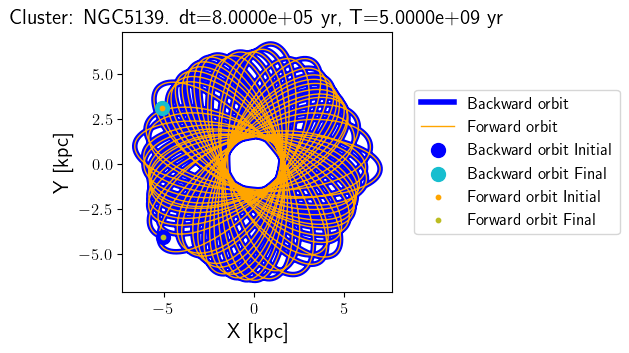

In [143]:
plotdata0={"x":backwardorbit[0],"y":backwardorbit[1]}
plotdata1={"x":forwardorbit[0],"y":forwardorbit[1]}
title="Cluster: {}. dt={:.4e} yr, T={:.4e} yr".format(targetGC,timestep,integrationtime)
axisconfig={'xlabel':"X [kpc]",'ylabel':"Y [kpc]",'aspect':'equal','title':title}
pltobj0={"label":"Backward orbit","color":"blue"}
pltobj1={"label":"Forward orbit","color":"orange"}
fig,axis=bsitt.plot_orbits([plotdata0,plotdata1],[pltobj0,pltobj1],axisconfig)

In [144]:
x_back = np.flip(backwardorbit[0])
x_forward = forwardorbit[0]
y_back = np.flip(backwardorbit[1])
y_forward = forwardorbit[1]
z_back = np.flip(backwardorbit[2])
z_forward = forwardorbit[2]
timearray = np.linspace(-integrationtime,0,len(x_back))* u.yr
timearray = timearray.to(unitT)
xmin = min(x_back)
xmax = max(x_back)
drift = np.sqrt((x_back-x_forward)**2 + (y_back-y_forward)**2 + (z_back-z_forward)**2)


(1e-14, 20.0)

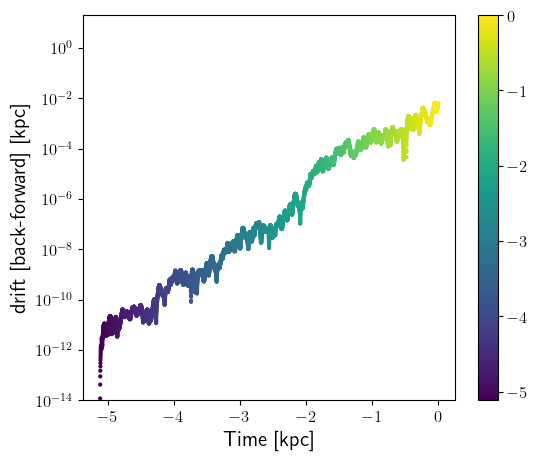

In [145]:
fig,axis=plt.subplots(1,1,figsize=(6,5))
im=axis.scatter(timearray,drift,c=timearray,cmap='viridis',s=4)
cbar = plt.colorbar(im, ax=axis)
# axis.plot([xmin,xmax],[xmin,xmax],color='black',linestyle='-',zorder=0)
axis.set_xlabel("Time [kpc]")
axis.set_ylabel("drift [back-forward] [kpc]")
axis.set_yscale('log')
axis.set_ylim(1e-14,2e1)

In [146]:
abar_x_forward = forwardaccel[1][0]
abar_x_backward = np.flip(backcaccel[1][0])
abar_y_forward = forwardaccel[1][1]
abar_y_backward = np.flip(backcaccel[1][1])
abar_z_forward = forwardaccel[1][2]
abar_z_backward = np.flip(backcaccel[1][2])
adrift = np.sqrt((abar_x_forward-abar_x_backward)**2 + (abar_y_forward-abar_y_backward)**2 + (abar_z_forward-abar_z_backward)**2)

(1e-14, 100.0)

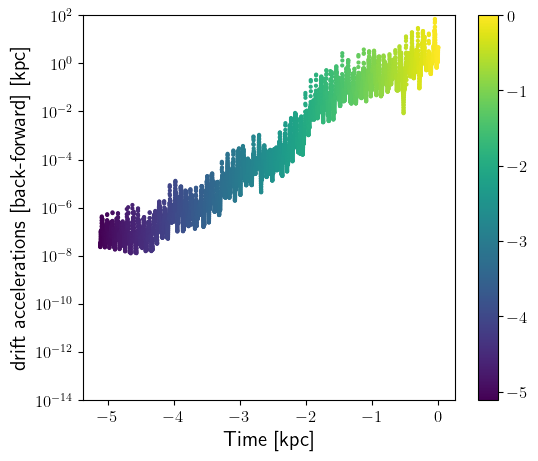

In [151]:
fig,axis=plt.subplots(1,1,figsize=(6,5))
im=axis.scatter(timearray,adrift,c=timearray,cmap='viridis',s=4)
cbar = plt.colorbar(im, ax=axis)
axis.set_yscale('log')
axis.set_xlabel("Time [kpc]")
axis.set_ylabel("drift accelerations [back-forward] [kpc]")
axis.set_ylim(1e-14,1e2)

In [148]:
thetaforward=forwardbartheta
thetaback=np.flip(backbartheta)
dtheta = np.sqrt((thetaforward-thetaback)**2)

Text(0, 0.5, 'Difference in bar angle [rad]')

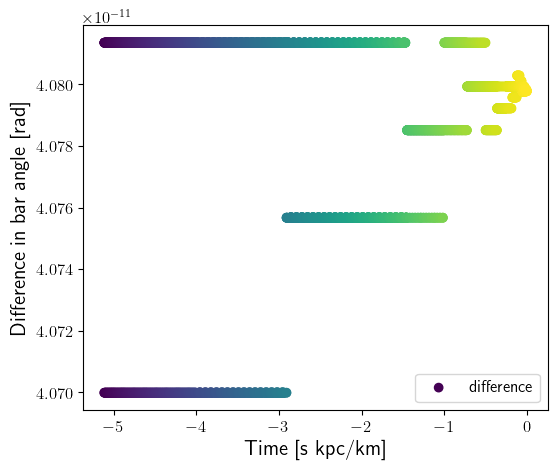

In [149]:
fig,axis=plt.subplots(1,1,figsize=(6,5))
axis.scatter(timearray,dtheta,label="difference",c=timearray)
axis.legend()
axis.set_xlabel("Time [s kpc/km]")
axis.set_ylabel("Difference in bar angle [rad]")

# Magnitude of the accelerations

In [152]:
abar_backward = np.sqrt(abar_x_backward**2 + abar_y_backward**2 + abar_z_backward**2)
abar_forward = np.sqrt(abar_x_forward**2 + abar_y_forward**2 + abar_z_forward**2)
aSG_backward = np.sqrt(backcaccel[0][0]**2 + backcaccel[0][1]**2 + backcaccel[0][2]**2)
aSG_forward = np.sqrt(forwardaccel[0][0]**2 + forwardaccel[0][1]**2 + forwardaccel[0][2]**2)
aSG_backward = np.flip(aSG_backward)

In [163]:
unitD/unitT**2

Unit("km2 / (kpc s2)")

Text(0, 0.5, 'Acceleration [km$^2$/ kpc s$^2$]')

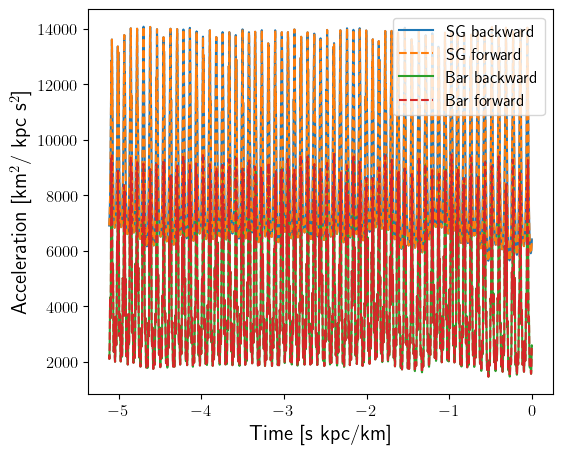

In [168]:
fig,axis=plt.subplots(1,1,figsize=(6,5))
axis.plot(timearray,aSG_backward,label="SG backward",zorder=0)
axis.plot(timearray,aSG_forward,label="SG forward",zorder=1,linestyle='--')
axis.plot(timearray,abar_backward,label="Bar backward",zorder=0)
axis.plot(timearray,abar_forward,label="Bar forward",zorder=1,linestyle='--')   
axis.legend()   
axis.set_xlabel("Time [s kpc/km]")
axis.set_ylabel("Acceleration [km$^2$/ kpc s$^2$]")